<a href="https://colab.research.google.com/github/vinayprabhu/Grassmannian_tutorials/blob/master/Equiangular_lines_1_2kp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook walks you through the procedure to generate $K$ equiangular line packing for $n$-dimensional spaces and angle of separation $cos^{-1}(\frac{1}{2k+1})$.

Notations:


*   $k \in \mathbb{Z}$: Positive integer (used to specify $\alpha$)
*   $\alpha$:= arccos(1/(2k+1)) (Angle of separation - The arccos is usually dropped in math papers) 
*   n:= Dimensionality of the embedding space (Or the 'Mother' dimension )
*   K:= Number of equiangular lines

STEPS:
1. Compute the Kernel matrix:   $M\in\mathbb{R}^{(k+1) \times (k+1)}:= (1+\alpha)I_{k+1}-\alpha E_{k+1}$ ( Kernel matrix)
2. Generate the Grammian matrix,$G\in \mathbb{R}^{\nu (k+1) \times \nu (k+1)}$, by repeating $M$,  $\nu=\frac{(n-1)}{k}$ times and setting $G[G==0]=\alpha$
(Note that the rank of this Grammian is $rank(G)=n=\nu k +1$)
3. Perform Jordan decomposition of $G=PDP^{-1}$
4. Now, D will have precisely K non-zero eigenvalues. Let's extract the sub-matrix of these $K$ non-zero eigenvalues out and also the eigenvectors associated with these to get $D_K$ and $P_K$ respectively.
5. Evaluated the yield the codebook matrix, $F=P_KD_K^{\frac{1}{2}} \in \mathbb{R}^{n \times K}$, where $K=\frac{k+1}{k}(n-1)$ (Note that the Grammian by definition is $G=FF^T$)

Examples:
1. For $\alpha=1/3$, we can pack $2(n-1)$ lines in $n$-D
2. For $\alpha=1/5$, we can pack $\frac{3}{2}(n-1)$ lines in $n$-D
3. For $\alpha=1/7$, we can pack $\frac{4}{3}(n-1)$ lines in $n$-D



In [1]:
import numpy as np
from scipy.linalg import block_diag
# Don't do linear algebra in Python without these two lines
np.set_printoptions(suppress=True)
from collections import Counter
import matplotlib.pyplot as plt

%precision 3

'%.3f'

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


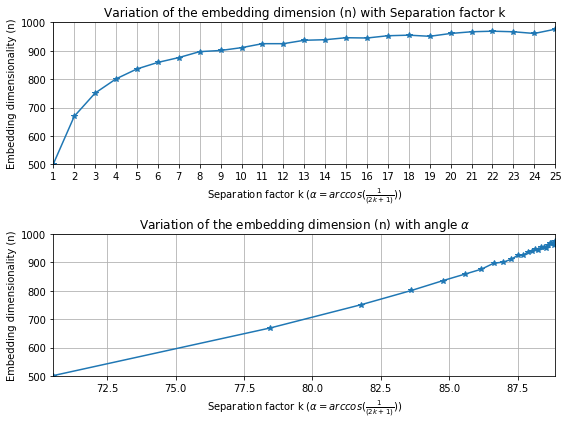

In [2]:
# Regarding the number of dimensions you will need:
def est_n(K,k=1):
  """
  # K :=This is the number of lines (or classes)
  # k:= This gives us the angle of sepration as np.arccos(alpha=1/(2*k+1))
  """
  # Step-1: Figure out how many dimensions you will need
  alpha=1/(2*k+1)
  # We know that n-D space can 'host'  K=((k+1)/k)*(n-1) lines that are arccos(1/(2*k+1)) apart
  # So, in ML classification problems, K is given (and the ML'er sets alpha). So, let's solve for n
  n_rep=int(np.ceil(K/(k+1)))
  return n_rep*k+1

n_vec=[]
k_vec=np.arange(1,26)
print(k_vec)
K=1000# ImageNet dataset
for k in k_vec:
  n_vec.append(est_n(K,k))

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(k_vec,n_vec,'-*');
plt.xticks(k_vec);
plt.grid('On')
plt.ylim([500,1000])
plt.xlim([1,25])
plt.xlabel(r'Separation factor k ($\alpha=arccos(\frac{1}{(2k+1)})$)')
plt.ylabel('Embedding dimensionality (n)')
plt.title('Variation of the embedding dimension (n) with Separation factor k')
plt.savefig('n_k.pdf',bbox_inches='tight')

plt.subplot(2,1,2)
ang_vec=np.rad2deg(np.abs(np.arccos(1/(2*k_vec+1))))
plt.plot(ang_vec,n_vec,'-*');
# plt.xticks(k_vec);
plt.grid('On')
plt.ylim([500,1000])
plt.xlim([ang_vec.min(),ang_vec.max()])
plt.xlabel(r'Separation factor k ($\alpha=arccos(\frac{1}{(2k+1)})$)')
plt.ylabel('Embedding dimensionality (n)')
plt.title(r'Variation of the embedding dimension (n) with angle $\alpha$')
plt.tight_layout()
plt.savefig('n_k_alpha.pdf',bbox_inches='tight')

# The generalized function that spits out the equiangular codebooks:

In [0]:
def elp_gen(K,k=1):
  """
  # K :=This is the number of lines (or classes)
  # k:= This gives us the angle of sepration as np.arccos(alpha=1/(2*k+1))
  """
  # Step-1: Figure out how many dimensions you will need
  alpha=1/(2*k+1)
  # We know that n-D space can 'host'  K=((k+1)/k)*(n-1) lines that are arccos(1/(2*k+1)) apart
  # So, in ML classification problems, K is given (and the ML'er sets alpha). So, let's solve for n
  n_rep=int(np.ceil(K/(k+1)))
  n=n_rep*k+1
  print(f'Given separation k={k}, i.e. alpha={np.round(alpha,3)} and number of lines {K}, \n the number of dimensions you will need is {n}')
  # Generate the kernel matrix
  M=(1+alpha)*np.eye(k+1)-alpha*np.ones((k+1,k+1))
  # Genrate the Grammian
  G = block_diag(*[M]*n_rep)
  G[G==0]=alpha
  print(f'The rank of the Grammian is {np.linalg.matrix_rank(G)}')
  # Perform Jordan decomposition and extract the codebook from the non-zero eigenvalue components
  D,P=np.linalg.eigh(G)
  code_columns=np.where(~ np.isclose(D,0))[0]
  P_code=P[0:K,code_columns]
  D_code=D[code_columns]
  F_code=P_code @ np.sqrt(np.diag(D_code)) 
  # Verification via Pairwise distance comparisons
  dist_mat=F_code @ F_code.T
  ang_vec=np.abs(np.round(dist_mat[np.triu_indices(dist_mat.shape[0])],3))
  print(f'The cos-angles in the codebook are {Counter(ang_vec)}')
  cond_1=len(np.unique(ang_vec))==2
  cond_2=np.allclose(ang_vec[ang_vec!=1],alpha,atol=1e-2)
  if(cond_1 & cond_2):
    file_name=f'embedding_{n}_{K}_{k}.npy'
    print(f'All the lines are {alpha} apart!\n   Saving the codebook as {file_name}')
    np.save(file_name, F_code)
  else:
    print(f'Lines are not {alpha} apart :( \n Something went wrong. No codebooks for you!)')
    F_code=np.empty(0)
  return F_code

# For the Imagenet dataset (K=1000)

In [4]:
K=1000
for k in range(1,5):
  elp_gen(K,k)

Given separation k=1, i.e. alpha=0.333 and number of lines 1000, 
 the number of dimensions you will need is 501
The rank of the Grammian is 501
The cos-angles in the codebook are Counter({0.333: 499500, 1.0: 1000})
All the lines are 0.3333333333333333 apart!
   Saving the codebook as embedding_501_1000_1.npy
Given separation k=2, i.e. alpha=0.2 and number of lines 1000, 
 the number of dimensions you will need is 669
The rank of the Grammian is 669
The cos-angles in the codebook are Counter({0.2: 499500, 1.0: 1000})
All the lines are 0.2 apart!
   Saving the codebook as embedding_669_1000_2.npy
Given separation k=3, i.e. alpha=0.143 and number of lines 1000, 
 the number of dimensions you will need is 751
The rank of the Grammian is 751
The cos-angles in the codebook are Counter({0.143: 499500, 1.0: 1000})
All the lines are 0.14285714285714285 apart!
   Saving the codebook as embedding_751_1000_3.npy
Given separation k=4, i.e. alpha=0.111 and number of lines 1000, 
 the number of dime